# Segmentation task on CT images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras.preprocessing.image
from keras.models import Model
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import shutil
from tqdm.notebook import tqdm

tf.config.run_functions_eagerly(True)

## Hyperparameters:

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
main_path_1 = '/content/drive/MyDrive/Final Dataset/'
main_path_2 = '/content/drive/MyDrive/Final Dataset Diag/'

## Reading Dataset Path:

In [ ]:
def read_data_path(input_dir, target_dir):
  input_img_paths = sorted(
      [
          os.path.join(input_dir, fname)
          for fname in os.listdir(input_dir)
          if fname.endswith(".png")
      ]
  )
  target_img_paths = sorted(
      [
          os.path.join(target_dir, fname)
          for fname in os.listdir(target_dir)
          if fname.endswith(".png") and not fname.startswith(".")
      ]
  )
  return input_img_paths, target_img_paths

In [ ]:
input_dir = main_path_1 + 'image/'
target_dir = main_path_1 + '2 - consolidation/mask/'

In [ ]:
input_img_paths, target_img_paths = read_data_path(input_dir, target_dir)
print("images length: ", len(input_img_paths))
print("masks length: ", len(target_img_paths))

images length:  1665
masks length:  1665


## Reading Dataset:

In [ ]:
def read_data(input_img_paths, target_img_paths):
  X = []
  Y = []

  for i in tqdm(range(len(input_img_paths))):
    img = cv2.imread(input_img_paths[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = np.reshape(img, (256,256,1))
    img = img.astype("float32")
    img/=255.0
    img1 = cv2.flip(img, 0)
    img1 = np.reshape(img1, (256,256,1))
    img2= cv2.flip(img, 1)
    img2 = np.reshape(img2, (256,256,1))
    img3 = cv2.flip(img, -1)
    img3 = np.reshape(img3, (256,256,1))
    X.append(img)
    X.append(img1)
    X.append(img2)
    X.append(img3)

    img = cv2.imread(target_img_paths[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = np.reshape(img, (256,256,1))
    img = img.astype("float32")
    img/=255.0
    img1 = cv2.flip(img, 0)
    img1 = np.reshape(img1, (256,256,1))
    img2= cv2.flip(img, 1)
    img2 = np.reshape(img2, (256,256,1))
    img3 = cv2.flip(img, -1)
    img3 = np.reshape(img3, (256,256,1))
    Y.append(img)
    Y.append(img1)
    Y.append(img2)
    Y.append(img3)
    
  return X, Y

In [ ]:
X, Y = read_data(input_img_paths, target_img_paths)

  0%|          | 0/1665 [00:00<?, ?it/s]

## Split Dataset:

In [ ]:
X = np.array(X)
Y = np.array(Y)

shuffler = np.random.permutation(len(X))
X = X[shuffler]
Y = Y[shuffler]

In [ ]:
train_test_split = int(len(X)*0.95)
X_train = X[:train_test_split]
Y_train = Y[:train_test_split]
X_test = X[train_test_split:]
Y_test = Y[train_test_split:]

## Dataset shape and type:

In [ ]:
print("train:")
print("shape: ", X_train.shape)
print("length: ", len(X_train))
print("type: ", type(X_train))

print("\ntest:")
print("shape: ", X_test.shape)
print("length: ", len(X_test))
print("type: ", type(X_test))

train:
shape:  (6327, 256, 256, 1)
length:  6327
type:  <class 'numpy.ndarray'>

test:
shape:  (333, 256, 256, 1)
length:  333
type:  <class 'numpy.ndarray'>


## Visualizing Data:<br>
Images:

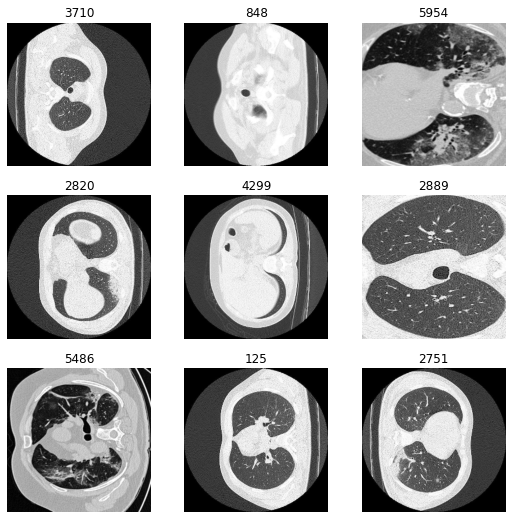

In [ ]:
index_list = []
plt.figure(figsize=(9,9))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),9))) :
    plt.subplot(3,3,n+1)
    plt.imshow(X_train[i][:,:,0],cmap='gray')
    plt.axis('off')
    plt.title(i)
    index_list.append(i)

Masks:

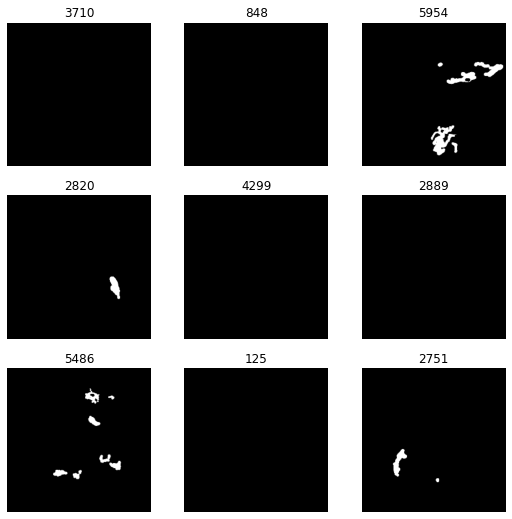

In [ ]:
plt.figure(figsize=(9,9))
n = i = 0
for _ in range(9) :
  plt.subplot(3,3,n+1)
  plt.imshow(Y_train[index_list[i]][:,:,0],cmap='gray')
  plt.axis('off')
  plt.title(index_list[i])
  n+=1
  i+=1

## Create Model:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

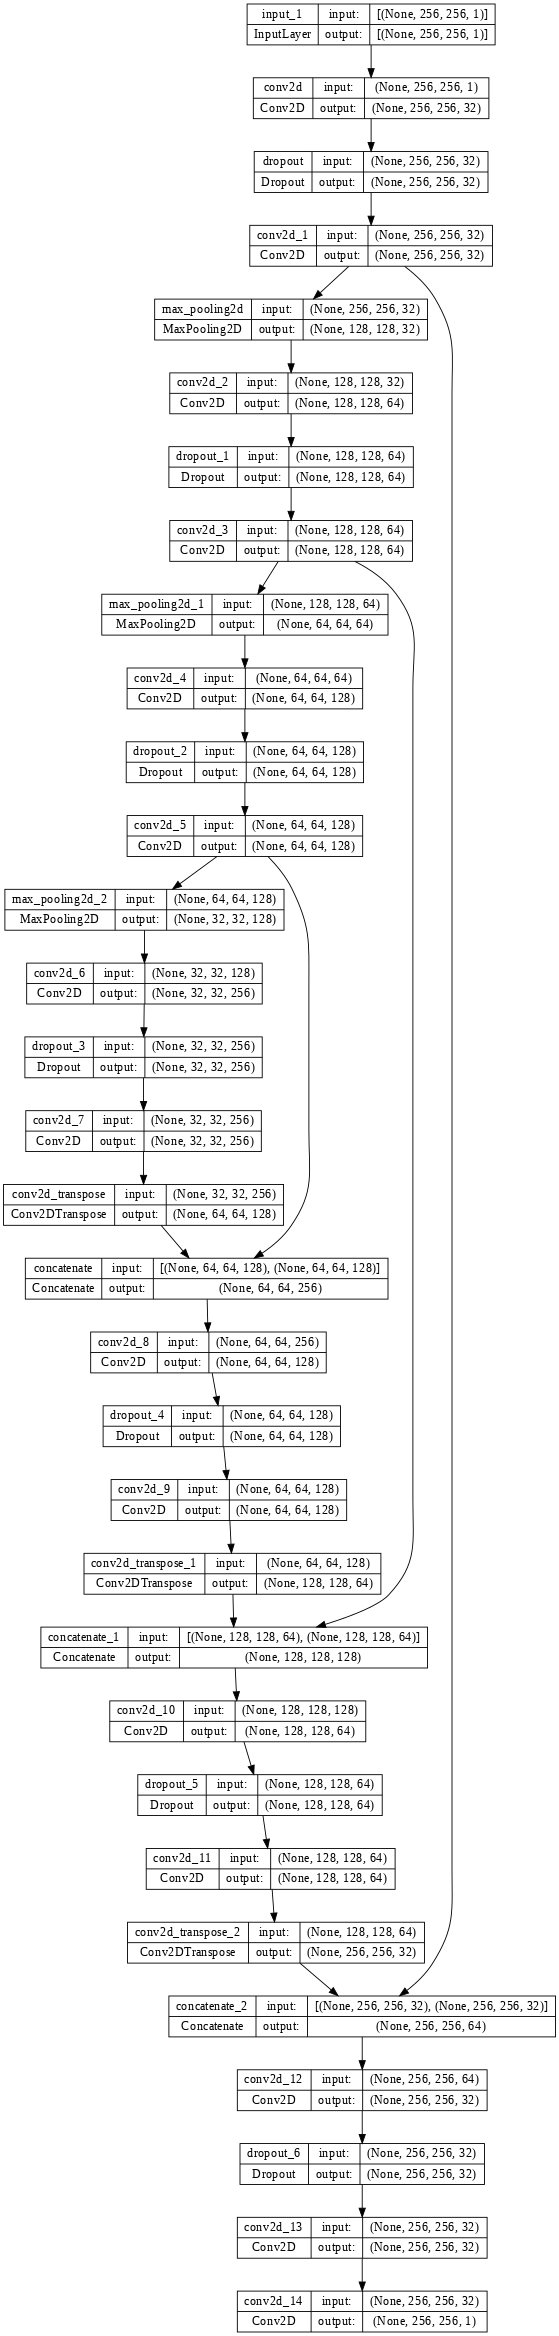

In [ ]:
def create_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = inputs

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)
  
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)
  
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
  
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
    
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

unet_model = create_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
unet_model.summary()
tf.keras.utils.plot_model(unet_model, show_shapes=True, dpi=64)

In [ ]:
EarlyStop=EarlyStopping(patience=7, restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy', verbose=2, factor=0.5, min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
callback=[EarlyStop , Reduce_LR, model_check]

## Train the Model:

In [ ]:
history = unet_model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, 
                  steps_per_epoch=len(X_train)//32, epochs=40,
                 callbacks = callback, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/40
197/197 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9879
Epoch 1: val_loss improved from inf to 0.05149, saving model to model.hdf5
197/197 [==============================] - 174s 806ms/step - loss: 0.0636 - accuracy: 0.9879 - val_loss: 0.0515 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 2/40
197/197 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9923
Epoch 2: val_loss improved from 0.05149 to 0.03894, saving model to model.hdf5
197/197 [==============================] - 149s 755ms/step - loss: 0.0372 - accuracy: 0.9923 - val_loss: 0.0389 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 3/40
197/197 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9926
Epoch 3: val_loss improved from 0.03894 to 0.03468, saving model to model.hdf5
197/197 [==============================] - 148s 749ms/step - loss: 0.0321 - accuracy: 0.9926 - val_loss: 0.0347 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 4/40
197/197 [===============

## Predicting:

In [ ]:
y_pred = unet_model.predict(X_test)

11/11 [==============================] - 3s 341ms/step


In [ ]:
y_pred.max()

0.9999356

In [ ]:
y_pred_p = (y_pred > y_pred.max()/2).astype(np.uint8)

## Visualizing the Result:

Real Masks:


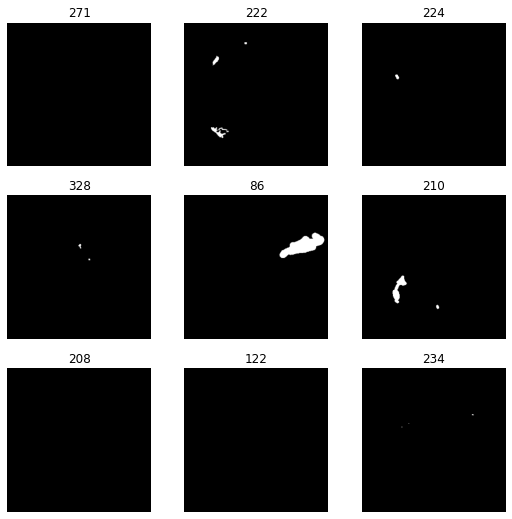


Predicted Masks:


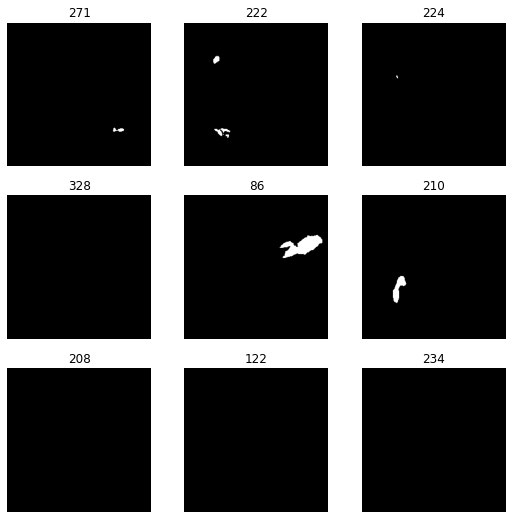

In [ ]:
print("Real Masks:")
index_list = []
plt.figure(figsize=(9,9))
for n ,i in enumerate(list(np.random.randint(0,len(Y_test),9))) :
    plt.subplot(3,3,n+1)
    plt.imshow(Y_test[i][:,:,0],cmap='gray')
    plt.axis('off')
    plt.title(i)
    index_list.append(i)
plt.show()
print("\nPredicted Masks:")
plt.figure(figsize=(9,9))
n = i = 0
for _ in range(9) :
  plt.subplot(3,3,n+1)
  plt.imshow(y_pred_p[index_list[i]][:,:,0],cmap='gray')
  plt.axis('off')
  plt.title(index_list[i])
  n+=1
  i+=1

## Saving The Model to use it in Diagnosis task:

In [ ]:
# shutil.copyfile('/content/model.hdf5', main_path_2 + 'Trained Models/consolidation_model.hdf5')

'/content/drive/MyDrive/AIMedic/Final Dataset Diag/Trained Models/ground_glass_model.hdf5'